In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt

## 1. Create a straight line dataset using the linear regression formula (weight * X + bias).

   * Set weight=0.3 and bias=0.9 there should be at least 100 datapoints total.
   * Split the data into 80% training, 20% testing.
   * Plot the training and testing data so it becomes visual.


In [2]:
X = torch.linspace(0, 10, 100).to('cuda') # at least 100 datapoints
X = X.unsqueeze(dim=1)
weight, bias = 0.3, 0.9
y = weight * X + bias

X[:10], y[:10]

(tensor([[0.0000],
         [0.1010],
         [0.2020],
         [0.3030],
         [0.4040],
         [0.5051],
         [0.6061],
         [0.7071],
         [0.8081],
         [0.9091]], device='cuda:0'),
 tensor([[0.9000],
         [0.9303],
         [0.9606],
         [0.9909],
         [1.0212],
         [1.0515],
         [1.0818],
         [1.1121],
         [1.1424],
         [1.1727]], device='cuda:0'))

In [3]:
# train test split
train_volume = 0.8
split = int(train_volume * len(X))

X_train, y_train = X[:split], y[:split]
X_test, y_test = X[split:], y[split:]

X_train.shape, y_train.shape, X_test.shape, y_test.shape

(torch.Size([80, 1]),
 torch.Size([80, 1]),
 torch.Size([20, 1]),
 torch.Size([20, 1]))

In [4]:
def plot_predictions(predictions=None):
    fig, ax = plt.subplots(figsize=(10, 7))
    ax.scatter(X_train.cpu(), y_train.cpu(), color='blue', label='training data')
    ax.scatter(X_test.cpu(), y_test.cpu(), color='green', label='test data')
    
    if predictions is not None:
        ax.scatter(X_test.cpu(), predictions.cpu(), color='red', label='predictions')
    ax.legend(prop={'size': 14})

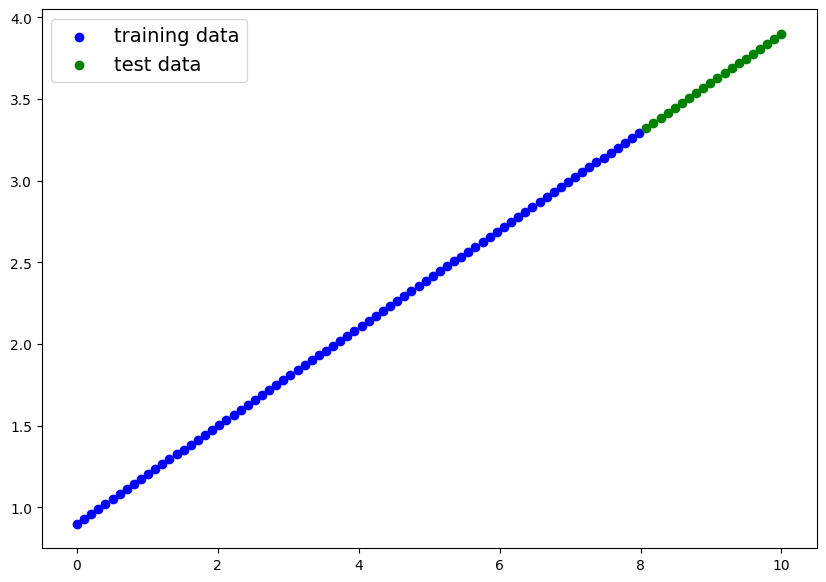

In [5]:
plot_predictions()

## 2. Build a PyTorch model by subclassing nn.Module.
  * Inside should be a randomly initialized nn.Parameter() with requires_grad=True, one for weights and one for bias.
  * Implement the forward() method to compute the linear regression function you used to create the dataset in 1.
  * Once you've constructed the model, make an instance of it and check its state_dict().
  * Note: If you'd like to use nn.Linear() instead of nn.Parameter() you can.

In [6]:
# From the pytorch documentation, the linear layer follows the linear equation
# https://pytorch.org/docs/stable/generated/torch.nn.Linear.html
class LinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_layer = nn.Linear(in_features=1,
                                      out_features=1)
    
    def forward(self, x):
        return self.linear_layer(x)

In [7]:
model = LinearRegressionModel().to('cuda')
model.state_dict()

OrderedDict([('linear_layer.weight', tensor([[-0.2110]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.5148], device='cuda:0'))])

## 3. Create a loss function and optimizer using nn.L1Loss() and torch.optim.SGD(params, lr) respectively.

  * Set the learning rate of the optimizer to be 0.01 and the parameters to optimize should be the model parameters from the model you created in 2.
  * Write a training loop to perform the appropriate training steps for 300 epochs.
  * The training loop should test the model on the test dataset every 20 epochs.

In [8]:
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(model.parameters(), 
                            lr=0.01)

In [9]:
# Training the model
epochs = 300
for epoch in range(epochs):
    model.train()
    y_pred_step = model(X_train)
    loss = loss_fn(y_pred_step, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if epoch % 20 == 0:
        model.eval()
        with torch.inference_mode():
            y_pred_test = model(X_test)
            loss = loss_fn(y_pred_test, y_test)
            
            print(f"Epoch {epoch}, loss: {loss}")
            print(model.state_dict())

Epoch 0, loss: 4.6342058181762695
OrderedDict([('linear_layer.weight', tensor([[-0.1711]], device='cuda:0')), ('linear_layer.bias', tensor([0.5248], device='cuda:0'))])
Epoch 20, loss: 0.11652828752994537
OrderedDict([('linear_layer.weight', tensor([[0.3370]], device='cuda:0')), ('linear_layer.bias', tensor([0.6821], device='cuda:0'))])
Epoch 40, loss: 0.09721117466688156
OrderedDict([('linear_layer.weight', tensor([[0.3269]], device='cuda:0')), ('linear_layer.bias', tensor([0.7541], device='cuda:0'))])
Epoch 60, loss: 0.09541976451873779
OrderedDict([('linear_layer.weight', tensor([[0.3203]], device='cuda:0')), ('linear_layer.bias', tensor([0.8123], device='cuda:0'))])
Epoch 80, loss: 0.3480575680732727
OrderedDict([('linear_layer.weight', tensor([[0.3434]], device='cuda:0')), ('linear_layer.bias', tensor([0.8561], device='cuda:0'))])
Epoch 100, loss: 0.2838924825191498
OrderedDict([('linear_layer.weight', tensor([[0.3337]], device='cuda:0')), ('linear_layer.bias', tensor([0.8796], de

### with GPU (training 300 epochs):
CPU times: user 1 µs, sys: 1e+03 ns, total: 2 µs
Wall time: 2.86 µs

### with CPU (training 300 epochs)
CPU times: user 1 µs, sys: 1e+03 ns, total: 2 µs
Wall time: 3.58 µs

## 4. Make predictions with the trained model on the test data.
  * Visualize these predictions against the original training and testing data (note: you may need to make sure the predictions are not on the GPU if you want to use non-CUDA-enabled libraries such as matplotlib to plot).

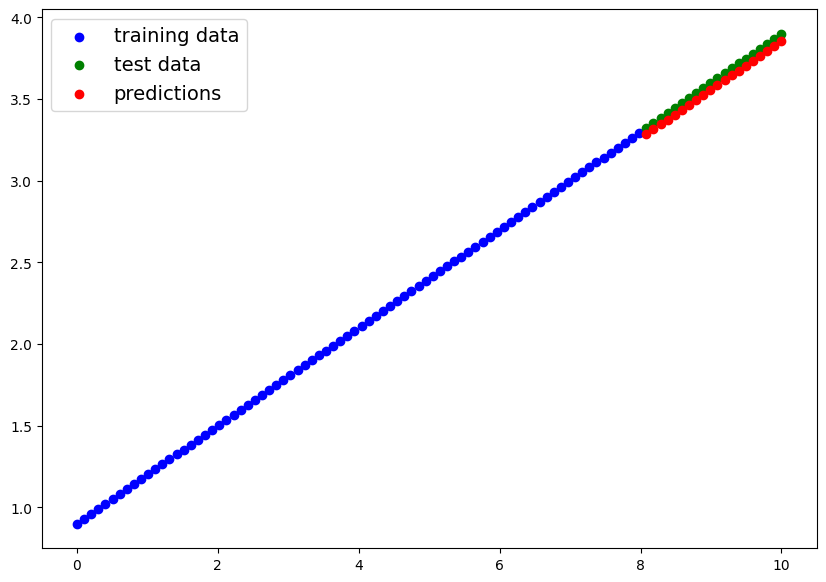

In [10]:
model.eval()
with torch.inference_mode():
    y_final_pred = model(X_test)
plot_predictions(y_final_pred)

## 5. Save your trained model's state_dict() to file
  * Create a new instance of your model class you made in 2. and load in the state_dict() you just saved to it.
  * Perform predictions on your test data with the loaded model and confirm they match the original model predictions from 4.

In [11]:
torch.save(model.state_dict(), "./models/exercise_model_state.pth")

In [12]:
loaded_model = LinearRegressionModel().to('cuda')
loaded_model.load_state_dict(torch.load("./models/exercise_model_state.pth"))

loaded_model.state_dict()


OrderedDict([('linear_layer.weight', tensor([[0.2964]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.8901], device='cuda:0'))])

In [13]:
loaded_model.eval()
with torch.inference_mode():
    loaded_model_preds = loaded_model(X_test)
    
loaded_model_preds == y_final_pred

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]], device='cuda:0')